<a href="https://colab.research.google.com/github/paulinaeb/IDaSec-project/blob/exp3/my_exp/before_evasion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone --branch main https://github.com/paulinaeb/IDaSec-project.git

Cloning into 'IDaSec-project'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 100 (delta 28), reused 71 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (100/100), 10.05 MiB | 13.81 MiB/s, done.
Resolving deltas: 100% (28/28), done.


# Libraries

In [ ]:
!pip uninstall -y torch torchtext

Found existing installation: torch 2.2.0
Uninstalling torch-2.2.0:
  Successfully uninstalled torch-2.2.0
Found existing installation: torchtext 0.17.0
Uninstalling torchtext-0.17.0:
  Successfully uninstalled torchtext-0.17.0


In [ ]:
# !pip install --upgrade torchtext
# !pip install --upgrade torch
!pip install torch==2.2.0 torchtext==0.17.0

  Using cached torch-2.2.0-cp311-cp311-manylinux1_x86_64.whl.metadata (25 kB)
  Using cached torchtext-0.17.0-cp311-cp311-manylinux1_x86_64.whl.metadata (7.6 kB)
Using cached torch-2.2.0-cp311-cp311-manylinux1_x86_64.whl (755.5 MB)
Using cached torchtext-0.17.0-cp311-cp311-manylinux1_x86_64.whl (2.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.2.0 which is incompatible.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.2.0 which is incompatible.


In [ ]:
import warnings as wrn
wrn.filterwarnings('ignore')

import os
import numpy
import pandas as pd
import torch
import torch
from torch.utils.data import DataLoader, Dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt


 # Read datasets

In [ ]:
# Path to the dataset folder
dataset_path = "IDaSec-project/dataset"

# List all subfolders in dataset
subfolders = [f.name for f in os.scandir(dataset_path) if f.is_dir()]
print("available datasets:", subfolders)

enron1_path = dataset_path + "/enron1"
enron2_path = dataset_path + "/enron2"
sms_path = dataset_path + "/sms"

enron1_files = os.listdir(enron1_path)
print(f"\nFiles in '{enron1_path}': {enron1_files}")

enron2_files = os.listdir(enron2_path)
print(f"\nFiles in '{enron2_path}': {enron2_files}")

sms_files = os.listdir(sms_path)
print(f"\nFiles in '{sms_path}': {sms_files}")

available datasets: ['sms', 'enron1', 'enron2']

Files in 'IDaSec-project/dataset/enron1': ['enron1_val.csv', 'enron1_test.csv', 'enron1_train.csv']

Files in 'IDaSec-project/dataset/enron2': ['enron2_val.csv', 'enron2_train.csv', 'enron2_test.csv']

Files in 'IDaSec-project/dataset/sms': ['train.csv', 'val.csv', 'test.csv']


## Enron1

In [ ]:
enron1_train = pd.read_csv(enron1_path + "/enron1_train.csv")
enron1_test = pd.read_csv(enron1_path + "/enron1_test.csv")
enron1_val = pd.read_csv(enron1_path + "/enron1_val.csv")

In [ ]:
enron1_train.head()

,email,target
0,"Subject: prom dress shopping hi , just wanted ...",ham
1,"Subject: hi agaain hello , welcome to pharm la...",spam
2,Subject: feedback monitor error - meter 984132...,ham
3,Subject: instructions to remove spyware / adwa...,spam
4,Subject: acrobat pro 7 . 0 $ 69 . 95 xp pro op...,spam


## Enron2

In [ ]:
enron2_train = pd.read_csv(enron2_path + "/enron2_train.csv")
enron2_test = pd.read_csv(enron2_path + "/enron2_test.csv")
enron2_val = pd.read_csv(enron2_path + "/enron2_val.csv")

In [ ]:
enron2_train.head()

,email,target
0,Subject: membership in the nsf vince : karen m...,ham
1,Subject: holiday gift thank you so much for yo...,ham
2,"Subject: re : real options vince , if you take...",ham
3,"Subject: men charset = windows - 1252 "" > vigo...",spam
4,Subject: vaal medz how t pestilent o save on y...,spam


## sms

In [ ]:
sms_train = pd.read_csv(sms_path + "/train.csv")
sms_test = pd.read_csv(sms_path + "/test.csv")
sms_val = pd.read_csv(sms_path + "/val.csv")

In [ ]:
sms_train.head()

,email,target
0,What to think no one saying clearly. Ok leave ...,ham
1,"FREE RING TONE just text \POLYS\"" to 87131. Th...",spam
2,"Trust me. Even if isn't there, its there.",ham
3,Hi dear we saw dear. We both are happy. Where ...,ham
4,"URGENT, IMPORTANT INFORMATION FOR O2 USER. TOD...",spam


# The model

In [ ]:
SEED = 42

torch.manual_seed(SEED)
torch.backends.cuda.deterministic = True

## Setup tokenizer and vocabulary

In [ ]:
# use tokenizer from SpaCy
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")

# define the function only in the email column
def yield_tokens(data_iter):
  for index, row in data_iter.iterrows():
        yield tokenizer(row['email'])

# Merge the training splits of all datasets before building vocab
merged_train = pd.concat([enron1_train, enron2_train, sms_train], ignore_index=True)
vocab = build_vocab_from_iterator(yield_tokens(merged_train), specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])

# setup label map
label_map = {"ham": 0, "spam": 1}


## Create datasets and dataloaders


In [ ]:
class TextDataset(Dataset):
    def __init__(self, data, vocab, tokenizer, label_map):
        self.data = data
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.label_map = label_map

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]  # <-- change this line
        text = torch.tensor(self.vocab(self.tokenizer(item['email'])), dtype=torch.long)
        label = torch.tensor(self.label_map[item['target']], dtype=torch.float)
        return text, label


In [ ]:
def collate_batch(batch):
    texts, labels = zip(*batch)
    lengths = torch.tensor([len(t) for t in texts])
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=vocab["<pad>"])
    labels = torch.stack(labels)
    return padded_texts, lengths, labels


In [ ]:
BATCH_SIZE = 64

############################ Enron1 ######################################
train_dataset_enron1 = TextDataset(enron1_train, vocab, tokenizer, label_map)
val_dataset_enron1 = TextDataset(enron1_val, vocab, tokenizer, label_map)
test_dataset_enron1 = TextDataset(enron1_test, vocab, tokenizer, label_map)

train_loader_enron1 = DataLoader(train_dataset_enron1, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_loader_enron1 = DataLoader(val_dataset_enron1, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader_enron1 = DataLoader(test_dataset_enron1, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)


############################ Enron2 ######################################
train_dataset_enron2 = TextDataset(enron2_train, vocab, tokenizer, label_map)
val_dataset_enron2 = TextDataset(enron2_val, vocab, tokenizer, label_map)
test_dataset_enron2 = TextDataset(enron2_test, vocab, tokenizer, label_map)

train_loader_enron2 = DataLoader(train_dataset_enron2, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_loader_enron2 = DataLoader(val_dataset_enron2, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader_enron2 = DataLoader(test_dataset_enron2, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)


############################ SMS ######################################
train_dataset_sms = TextDataset(sms_train, vocab, tokenizer, label_map)
val_dataset_sms = TextDataset(sms_val, vocab, tokenizer, label_map)
test_dataset_sms = TextDataset(sms_test, vocab, tokenizer, label_map)

train_loader_sms = DataLoader(train_dataset_sms, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_loader_sms = DataLoader(val_dataset_sms, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader_sms = DataLoader(test_dataset_sms, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)


## LSTMNet model

In [ ]:
import torch.nn as nn

class LSTMNet(nn.Module):

    def __init__(self,vocab_size,embedding_dim,hidden_dim,output_dim,n_layers,bidirectional,dropout):

        super(LSTMNet,self).__init__()

        # Embedding layer converts integer sequences to vector sequences
        self.embedding = nn.Embedding(vocab_size,embedding_dim)

        # LSTM layer process the vector sequences
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout,
                            batch_first = True
                           )

        # Dense layer to predict
        self.fc = nn.Linear(hidden_dim * 2,output_dim)
        # Prediction activation function
        self.sigmoid = nn.Sigmoid()


    def forward(self,text,text_lengths):
        embedded = self.embedding(text)
        # Thanks to packing, LSTM don't see padding tokens
        # and this makes our model better
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False
        )

        packed_output,(hidden_state,cell_state) = self.lstm(packed_embedded)

        # Concatenating the final forward and backward hidden states
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)

        dense_outputs=self.fc(hidden)

        #Final activation function
        outputs=self.sigmoid(dense_outputs)

        return outputs



In [ ]:
# Replacing TEXT.vocab with our new vocab
SIZE_OF_VOCAB = len(vocab)
EMBEDDING_DIM = 100
NUM_HIDDEN_NODES = 64
NUM_OUTPUT_NODES = 1
NUM_LAYERS = 2
BIDIRECTION = True
DROPOUT = 0.2

model = LSTMNet(SIZE_OF_VOCAB,
                EMBEDDING_DIM,
                NUM_HIDDEN_NODES,
                NUM_OUTPUT_NODES,
                NUM_LAYERS,
                BIDIRECTION,
                DROPOUT
               )


## Optimizer and Loss function

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Binary Cross Entropy (for binary classification)
criterion = nn.BCELoss()
criterion = criterion.to(device)


In [ ]:
def binary_accuracy(preds, y):
    # round predictions to 0 or 1
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc


## Train and Evaluate loop

In [ ]:
def train(model, dataloader, optimizer, criterion):
    epoch_loss = 0.0
    epoch_acc = 0.0

    model.train()

    for text, text_lengths, labels in dataloader:
        text = text.to(device)
        text_lengths = text_lengths.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()

        predictions = model(text, text_lengths).squeeze(1)

        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)


In [ ]:
def evaluate(model, dataloader, criterion):
    epoch_loss = 0.0
    epoch_acc = 0.0

    model.eval()

    with torch.no_grad():
        for text, text_lengths, labels in dataloader:
            text = text.to(device)
            text_lengths = text_lengths.to(device)
            labels = labels.to(device).float()

            predictions = model(text, text_lengths).squeeze(1)

            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)


In [ ]:
EPOCH_NUMBER = 15

# train and evaluate and save model function
def train_evaluate_save_loop(model, train_loader, val_loader, optimizer, criterion,dataset_name,epochs=EPOCH_NUMBER,patience=3):
  best_val_loss = float("inf")
  epochs_no_improve = 0
  train_loss_history = []
  val_loss_history = []
  for epoch in range(1, EPOCH_NUMBER + 1):
      train_loss, train_acc = train(model, train_loader, optimizer, criterion)
      valid_loss, valid_acc = evaluate(model, val_loader, criterion)

      train_loss_history.append(train_loss)
      val_loss_history.append(valid_loss)
      print(f"Epoch: {epoch}")
      print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
      print()
      if valid_loss < best_val_loss:
          best_val_loss = valid_loss
          torch.save(model.state_dict(), f"{dataset_name}_model_weights.pth")
          epochs_no_improve = 0
      else:
          epochs_no_improve += 1

      if epochs_no_improve >= patience:
          print("Early stopping triggered.")
          break
  with open(f"{dataset_name}_loss_history.pkl", "wb") as f:
    pickle.dump((train_loss_history, val_loss_history), f)
  return train_loss_history, val_loss_history

# plot losses function
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Losses")
    plt.legend()
    plt.grid(True)
    plt.show()

# review model performance function
def test_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for text, lengths, labels in data_loader:
            text, lengths, labels = text.to(device), lengths.to(device), labels.to(device)
            outputs = model(text, lengths).squeeze()

            preds = torch.round(outputs)

            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    report = classification_report(all_labels, all_preds, zero_division=0)
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("\nClassification Report:\n", report)


## Run model on different datasets

### Enron1

Epoch: 1
Train Loss: 0.203 | Train Acc: 92.90%
Val. Loss: 0.258 |  Val. Acc: 92.07%

Epoch: 2
Train Loss: 0.104 | Train Acc: 96.47%
Val. Loss: 0.231 |  Val. Acc: 91.71%

Epoch: 3
Train Loss: 0.074 | Train Acc: 97.56%
Val. Loss: 0.221 |  Val. Acc: 92.19%

Epoch: 4
Train Loss: 0.055 | Train Acc: 98.46%
Val. Loss: 0.183 |  Val. Acc: 93.87%

Epoch: 5
Train Loss: 0.047 | Train Acc: 98.43%
Val. Loss: 0.168 |  Val. Acc: 94.47%

Epoch: 6
Train Loss: 0.042 | Train Acc: 98.74%
Val. Loss: 0.153 |  Val. Acc: 95.19%

Epoch: 7
Train Loss: 0.035 | Train Acc: 99.09%
Val. Loss: 0.153 |  Val. Acc: 95.19%

Epoch: 8
Train Loss: 0.031 | Train Acc: 99.28%
Val. Loss: 0.173 |  Val. Acc: 94.23%

Epoch: 9
Train Loss: 0.028 | Train Acc: 99.25%
Val. Loss: 0.181 |  Val. Acc: 94.71%

Early stopping triggered.


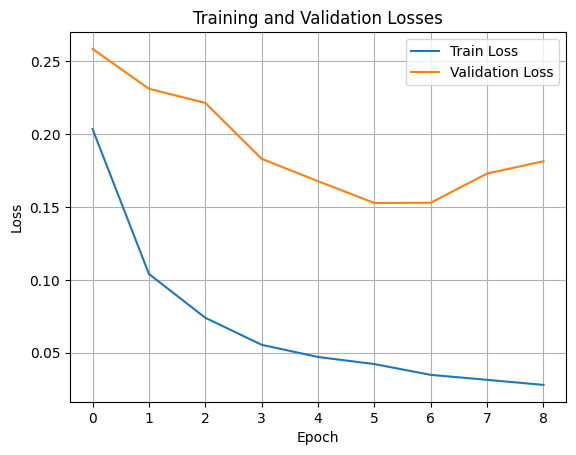

Accuracy: 0.9349
Precision: 0.9385
Recall: 0.8328
F1-score: 0.8825

Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.98      0.96       706
         1.0       0.94      0.83      0.88       293

    accuracy                           0.93       999
   macro avg       0.94      0.91      0.92       999
weighted avg       0.94      0.93      0.93       999



In [ ]:
# train and evaluate the model on enron1
enron1_train_loss_history,enron1_valid_loss_history = train_evaluate_save_loop(model, train_loader_enron1, val_loader_enron1, optimizer, criterion,dataset_name='enron1')

# plot the losses
plot_losses(enron1_train_loss_history, enron1_valid_loss_history)

# test the model
test_model(model, test_loader_enron1)


### Enron2

Epoch: 1
Train Loss: 0.076 | Train Acc: 97.11%
Val. Loss: 0.127 |  Val. Acc: 94.92%

Epoch: 2
Train Loss: 0.042 | Train Acc: 98.78%
Val. Loss: 0.112 |  Val. Acc: 95.67%

Epoch: 3
Train Loss: 0.036 | Train Acc: 98.88%
Val. Loss: 0.124 |  Val. Acc: 95.28%

Epoch: 4
Train Loss: 0.032 | Train Acc: 99.18%
Val. Loss: 0.159 |  Val. Acc: 94.90%

Epoch: 5
Train Loss: 0.044 | Train Acc: 98.41%
Val. Loss: 0.108 |  Val. Acc: 96.77%

Epoch: 6
Train Loss: 0.027 | Train Acc: 98.93%
Val. Loss: 0.167 |  Val. Acc: 94.32%

Epoch: 7
Train Loss: 0.044 | Train Acc: 98.38%
Val. Loss: 0.108 |  Val. Acc: 96.06%

Epoch: 8
Train Loss: 0.029 | Train Acc: 99.15%
Val. Loss: 0.088 |  Val. Acc: 96.98%

Epoch: 9
Train Loss: 0.015 | Train Acc: 99.68%
Val. Loss: 0.089 |  Val. Acc: 96.98%

Epoch: 10
Train Loss: 0.012 | Train Acc: 99.79%
Val. Loss: 0.091 |  Val. Acc: 96.98%

Epoch: 11
Train Loss: 0.011 | Train Acc: 99.74%
Val. Loss: 0.092 |  Val. Acc: 97.08%

Early stopping triggered.


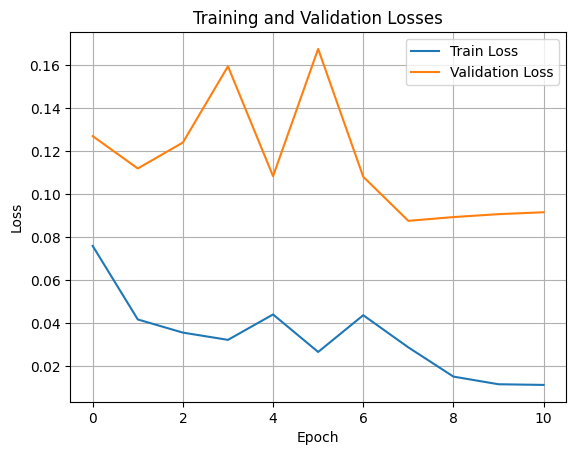

Accuracy: 0.9631
Precision: 0.9444
Recall: 0.9097
F1-score: 0.9267

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       866
         1.0       0.94      0.91      0.93       299

    accuracy                           0.96      1165
   macro avg       0.96      0.95      0.95      1165
weighted avg       0.96      0.96      0.96      1165



In [ ]:
# train and evaluate the model on enron1
enron2_train_loss_history,enron2_valid_loss_history = train_evaluate_save_loop(model, train_loader_enron2, val_loader_enron2, optimizer, criterion,dataset_name='enron2')

# plot the losses
plot_losses(enron2_train_loss_history, enron2_valid_loss_history)

# test the model
test_model(model, test_loader_enron2)


### SMS

Epoch: 1
Train Loss: 0.090 | Train Acc: 97.15%
Val. Loss: 0.180 |  Val. Acc: 94.84%

Epoch: 2
Train Loss: 0.058 | Train Acc: 98.60%
Val. Loss: 0.169 |  Val. Acc: 95.63%

Epoch: 3
Train Loss: 0.048 | Train Acc: 99.01%
Val. Loss: 0.165 |  Val. Acc: 95.85%

Epoch: 4
Train Loss: 0.037 | Train Acc: 99.16%
Val. Loss: 0.165 |  Val. Acc: 96.07%

Epoch: 5
Train Loss: 0.034 | Train Acc: 99.22%
Val. Loss: 0.159 |  Val. Acc: 95.97%

Epoch: 6
Train Loss: 0.030 | Train Acc: 99.36%
Val. Loss: 0.160 |  Val. Acc: 95.97%

Epoch: 7
Train Loss: 0.027 | Train Acc: 99.33%
Val. Loss: 0.161 |  Val. Acc: 95.96%

Epoch: 8
Train Loss: 0.023 | Train Acc: 99.50%
Val. Loss: 0.162 |  Val. Acc: 95.96%

Early stopping triggered.


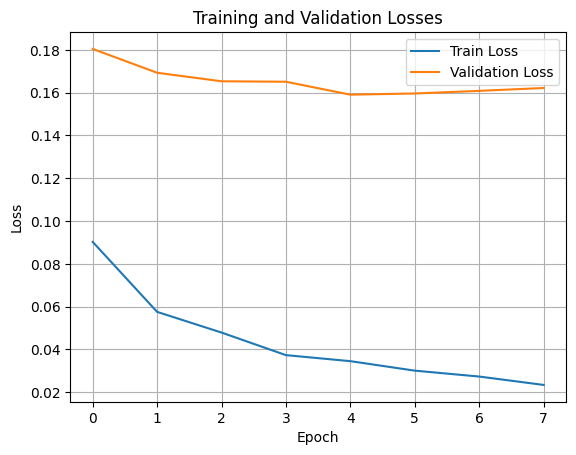

Accuracy: 0.9605
Precision: 0.9070
Recall: 0.7852
F1-score: 0.8417

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       966
         1.0       0.91      0.79      0.84       149

    accuracy                           0.96      1115
   macro avg       0.94      0.89      0.91      1115
weighted avg       0.96      0.96      0.96      1115



In [ ]:
# train and evaluate the model on enron1
sms_train_loss_history,sms_valid_loss_history = train_evaluate_save_loop(model, train_loader_sms, val_loader_sms, optimizer, criterion,dataset_name='sms')

# plot the losses
plot_losses(sms_train_loss_history, sms_valid_loss_history)

# test the model
test_model(model, test_loader_sms)
